# Environment Modules
* Scikit-learn - 0.20.0
* XGBoost - 0.90
* numpy - 1.15.4
* pandas - 0.24.2
* seaborn - 0.9.0
* matplotlib - 3.1.0
* jupyter - 5.7.8
## Used Training data set
[WSDM](https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data) - KKBox's Music Recommendation Challenge by isrc
## Used Test Music Recommendation  
'>' activate test
## Description
In this task, you will be asked to predict the chances of a user listening to a song repetitively after the first observable listening event within a time window was triggered. If there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, its target is marked 1, and 0 otherwise in the training set. The same rule applies to the testing set.

In [104]:
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn import metrics, ensemble
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### Load data

In [105]:
df = pd.read_csv('./data/train.csv')

### Sample of items(1%)
* 0.01 > 0.1%
* 0.1 > 1%

In [106]:
df = df.sample(frac=0.0001)

### Load and Merge _songs_ data

In [107]:
songs = pd.read_csv('./data/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

### Load and Merge _members_ data

In [108]:
members = pd.read_csv('./data/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

### DataFrame Information
* Total Index : 73,774,170(100%) -> 1.0+@(__GB__)
* Used Index : 737,741(1%) -> 106.9+@(__MB__)
* predict Index : 7,374(0.1%) - > 10.7+@(__MB__)

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738 entries, 0 to 737
Data columns (total 18 columns):
msno                      738 non-null object
song_id                   738 non-null object
source_system_tab         735 non-null object
source_screen_name        701 non-null object
source_type               735 non-null object
target                    738 non-null int64
song_length               738 non-null int64
genre_ids                 731 non-null object
artist_name               738 non-null object
composer                  564 non-null object
lyricist                  410 non-null object
language                  738 non-null float64
city                      738 non-null int64
bd                        738 non-null int64
gender                    447 non-null object
registered_via            738 non-null int64
registration_init_time    738 non-null int64
expiration_date           738 non-null int64
dtypes: float64(1), int64(7), object(10)
memory usage: 109.5+ KB


### Null Data Count(%)

In [110]:
df.isnull().sum()/df.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.406504
source_screen_name         5.013550
source_type                0.406504
target                     0.000000
song_length                0.000000
genre_ids                  0.948509
artist_name                0.000000
composer                  23.577236
lyricist                  44.444444
language                   0.000000
city                       0.000000
bd                         0.000000
gender                    39.430894
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

### Replace(delete) NULL >>> unknown

In [111]:
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

### Create Dates
Date format :%Y%m%d  
Used each date format

In [112]:
# registration_init_time(초기 등록 일자)
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date(마감 일자)
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [113]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,OqLPHCE0NFDQrEw67zOqJcz9bU+mv4976hQMZw5lZn8=,uBVNqsMG/EXKeLzF0P/wLWksVQupYVvsgC2Wg/FzW1I=,my library,unknown,top-hits-for-artist,1,244506,465,林宥嘉 (Yoga Lin),李拾壹,...,female,9,2011-05-01,2018-05-23,2011,5,1,2018,5,23
1,iiRxGn+xY7Kh0CnjdHgbI+nJYO5AWkYB1F0igkOsOpQ=,k1ewEUroVvxUeWr66+0vvUFaZ+6DZmwcAf9IwgczRoM=,my library,Local playlist more,local-library,1,265404,465,戴愛玲 (Ailing Tai),Joon-shin Yoon,...,male,3,2014-01-12,2017-09-24,2014,1,12,2017,9,24
2,xYiJD+Qbi9z2MmI5vb11M3ryrUnDTvXBuceRSMGU44U=,Ot8WIXZXzvgZeZoCwcimfORgLbZJJdslmuvO1ufZB7k=,my library,Local playlist more,local-library,1,234579,465,韋禮安 (William Wei),韋禮安,...,unknown,7,2016-09-09,2017-09-08,2016,9,9,2017,9,8
3,SNDk1c8tf4TApTuZDtqk9kWW8bR/7tFMqJ/FkwQV3ew=,xHZZseku/k6WdAath2h/69kAXZIWfVQwH1SYpLVXJXA=,my library,Local playlist more,local-library,1,313144,465,房祖名 (Jaycee),龔芝怡,...,female,7,2014-01-09,2017-07-19,2014,1,9,2017,7,19
4,wq1HicsSTn4qS8QootBB5kU26ppNW43y4S2cVfUsOp4=,eaEPf0VwQhIvfAm8xzQucpa0/OnWo18Ig1cfMIUsZ3M=,my library,Local playlist more,local-library,1,252447,465,Ellie Goulding,Max Martin| Ali Payami| Ilya Salmanzadeh| Sava...,...,male,9,2011-08-02,2017-11-03,2011,8,2,2017,11,3


### Type of category
make date group for each date format

In [114]:
# Date to category
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [115]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

### Сorrelation matrix

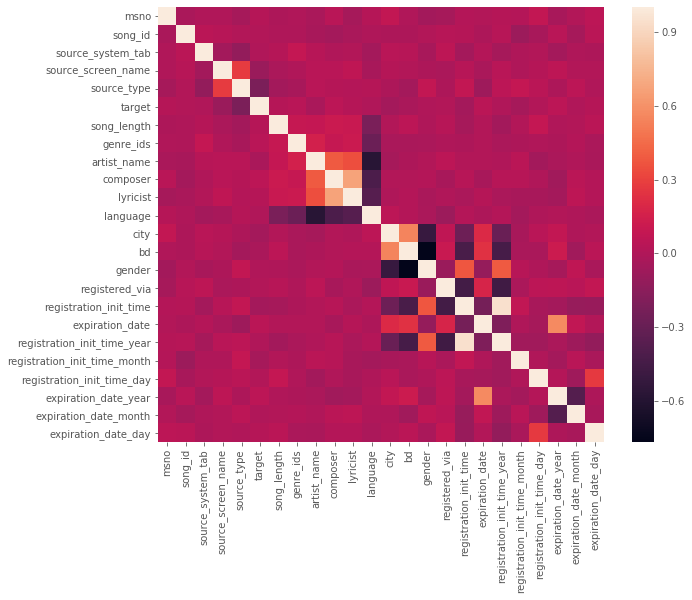

In [116]:
plt.figure(figsize=[10,8])
sns.heatmap(df.corr())
plt.show()

### Drop columns

In [117]:
df = df.drop(['expiration_date', 'lyricist'], 1)

In [123]:
df.head(20)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,bd,gender,registered_via,registration_init_time,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,313,620,3,14,9,1,244506,25,319,338,...,24,0,9,163,2011,5,1,2018,5,23
1,507,512,3,7,2,1,265404,25,298,113,...,26,1,3,332,2014,1,12,2017,9,24
2,681,273,3,7,2,1,234579,25,418,430,...,0,2,7,574,2016,9,9,2017,9,8
3,332,657,3,7,2,1,313144,25,299,439,...,28,0,7,331,2014,1,9,2017,7,19
4,671,452,3,7,2,1,252447,25,80,169,...,27,1,9,182,2011,8,2,2017,11,3
5,135,310,3,7,2,1,277420,25,414,423,...,0,2,7,171,2011,6,16,2017,9,15
6,43,436,0,14,5,1,257184,25,159,211,...,0,2,7,457,2015,9,12,2017,10,6
7,255,44,6,1,9,0,249939,25,5,63,...,29,1,7,376,2014,9,19,2017,9,10
8,374,644,2,10,1,0,217861,23,288,261,...,0,2,7,355,2014,5,16,2017,10,3
9,629,334,6,12,7,0,274494,25,322,350,...,23,0,9,189,2011,8,26,2017,10,14


In [124]:
df.to_csv("test.csv")

### Train & Test split

In [125]:
target = df.pop('song_id')
train_data, test_data, train_labels, test_labels = train_test_split(df, target, test_size = 0.25)

In [126]:
model = xgb.XGBRegressor(colsample_bytree=0.2, learning_rate=0.06,  max_depth=15, n_estimators=1150)
# model = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=150)
model.fit(train_data, train_labels)

[10:53:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.2, gamma=0,
       importance_type='gain', learning_rate=0.06, max_delta_step=0,
       max_depth=15, min_child_weight=1, missing=None, n_estimators=1150,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [136]:
Result = model.predict(test_data)
Num = Result.astype(int)
Num

array([297, 260, 369, 378, 347, 268, 335, 295, 382, 418, 273, 341, 295,
       260, 472, 354, 391, 386, 358, 371, 343, 408, 428, 343, 451, 332,
       407, 309, 414, 368, 347, 388, 466, 285, 340, 328, 364, 374, 428,
       400, 295, 309, 293, 537, 230, 333, 467, 337, 296, 439, 343, 363,
       219, 464, 461, 326, 383, 311, 354, 150, 433, 279, 320, 303, 319,
       344, 379, 377, 395, 364, 412, 459, 343, 325, 376, 243, 281, 428,
       356, 403, 353, 401, 375, 437, 334, 426, 359, 282, 311, 359, 389,
       362, 366, 462, 434, 375, 278, 392, 290, 355, 464, 281, 365, 326,
       352, 428, 334, 307, 367, 364, 463, 243, 351, 290, 437, 364, 344,
       357, 338, 302, 302, 347, 336, 399, 301, 326, 350, 340, 339, 309,
       418, 341, 288, 343, 399, 347, 381, 321, 399, 240, 269, 409, 321,
       369, 299, 300, 256, 281, 403, 366, 323, 476, 396, 453, 427, 311,
       314, 274, 442, 377, 377, 294, 329, 320, 412, 299, 366, 365, 431,
       290, 418, 354, 346, 448, 430, 405, 381, 393, 317, 363, 28

In [130]:
model.save_model('./Result.h5')

In [137]:
my_result = pd.DataFrame({'ID': test_data.msno, 'Song_id': Num})

In [138]:
my_result.to_csv("result_validate.csv")